In [1]:
from ngsolve import *
from ngsolve.meshes import Make1DMesh
from ngsolve.webgui import Draw

In [2]:
# use material parameters such that equations simplify
mu, lam = 0.5, 0  # Lame parameter
nu = lam/(2*(lam+mu)) # Possion ratio (=0)
E = mu*(3*lam+2*mu)/(lam+mu) # Young's modulus (=1)

# uniform distributed load
q = -500.0

In [3]:
from sympy import symbols, simplify, solve, diff, lambdify
X, C1, C2, C3, C4 = symbols("x C1 C2 C3 C4")
w_ex = q/2*X**4+C1/6*X**3+C2/2*X**2+C3*X+C4
w_diff_ex = 2*q*X**3+C1/2*X**2+C2*X+C3
w_ddiff_ex = 6*q*X**2+C1*X+C2


# solve for boundary conditions
solve_bc = solve((w_ex.subs(X,0), w_diff_ex.subs(X,0), w_ddiff_ex.subs(X,1), diff(w_ddiff_ex,X).subs(X,1)), C1, C2, C3, C4)
c1,c2,c3,c4 = solve_bc[C1], solve_bc[C2], solve_bc[C3], solve_bc[C4]

# generate CoefficientFunctions
w_ex_func = lambdify((X), w_ex.subs([(C1,c1),(C2,c2),(C3,c3),(C4,c4)]))
cf_w_ex = w_ex_func(x)
cf_sigma_ex = 1/12*cf_w_ex.Diff(x).Diff(x)


# Test boundary conditions
print("test: w(0)    = ", w_ex.subs([(X,0),(C1,c1),(C2,c2),(C3,c3),(C4,c4)]))
print("test: w'(0)   = ", w_diff_ex.subs([(X,0),(C1,c1),(C2,c2),(C3,c3),(C4,c4)]))
print("test: w''(1)  = ", w_ddiff_ex.subs([(X,1),(C1,c1),(C2,c2),(C3,c3),(C4,c4)]))
print("test: w'''(1) = ", diff(w_ddiff_ex,X).subs([(X,1),(C1,c1),(C2,c2),(C3,c3),(C4,c4)]))

print("test: w(1)    = ", w_ex.subs([(X,1),(C1,c1),(C2,c2),(C3,c3),(C4,c4)]))

test: w(0)    =  0.0
test: w'(0)   =  0.0
test: w''(1)  =  0
test: w'''(1) =  0
test: w(1)    =  -750.000000000000


In [4]:
mesh = Make1DMesh(100)

In [5]:
fes = H1(mesh, order=1, dirichlet="left")*H1(mesh, order=1, dirichlet="right")
(u,sigma),(du,dsigma) = fes.TnT()
    
    
    
a = BilinearForm(fes, symmetric=True)
a += (12*sigma*dsigma + grad(u)*grad(dsigma) + grad(du)*grad(sigma))*dx
    
f = LinearForm(fes)
f += -q*du*dx
    
gfsol = GridFunction(fes)
    
a.Assemble()
f.Assemble()
gfsol.vec.data = a.mat.Inverse(fes.FreeDofs(),inverse="umfpack")*f.vec
gfw, gfsigma = gfsol.components

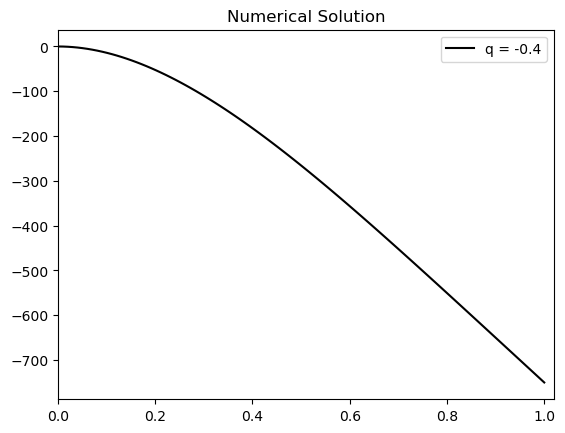

In [6]:
import numpy as np
import matplotlib.pyplot as plt
x=np.linspace(0,1,100)
gfw(mesh(x))

plt.plot(x,gfw(mesh(x)),color='black',label='q = -0.4',linestyle="-")
# plt.ylim([-10, 10])
plt.xlim([0, 1.02])
plt.title("Numerical Solution")
plt.legend()